In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [2]:
df = pd.read_json('exps.jsonl', lines=True)

df.dropna(inplace=True, how='any')

mask = df['params.evaluation.dataset.split'] == 'dev'
df = df[mask].copy()

cols2drop = ['id']
for col in df.columns:
    if len(df[col].unique()) == 1:
        cols2drop.append(col)
df.drop(columns=cols2drop, inplace=True)

df

,name,params.train.optimizer,params.program.prompting,params.lm.model,params.lm.temperature,params.run,metrics.exact.precision,metrics.exact.recall,metrics.exact.f1,metrics.fuzzy.precision,metrics.fuzzy.recall,metrics.fuzzy.f1
0,lathy-jaws,noop,sft,llama-3-8b-sft,0.0,low,0.630100,0.622543,0.623483,0.850379,0.847531,0.844171
1,moral-prof,noop,sft,llama-3-8b-sft,0.0,high,0.945660,0.939192,0.941871,0.980038,0.973275,0.976060
2,spicy-teff,noop,sft,llama-3-8b-sft,0.0,medium,0.826799,0.806647,0.814956,0.942006,0.920719,0.929080
3,gawsy-paps,bfsrs-ulti,structured,llama-3-8b,0.0,1,0.320626,0.319126,0.318514,0.698233,0.695948,0.693846
7,heigh-mope,bfsrs-medium,structured,llama-3-8b,0.5,1,0.251933,0.243802,0.246764,0.650937,0.628296,0.636171
8,kooky-choc,miprov2-medium,structured,llama-3-8b,0.5,1,0.230381,0.214486,0.220995,0.643391,0.597861,0.615783
9,modal-huck,bfsrs-high,structured,llama-3-8b,0.5,1,0.274224,0.268814,0.269906,0.666549,0.656943,0.657637
10,soupy-beak,miprov2-light,structured,llama-3-8b,0.5,1,0.156149,0.156003,0.155215,0.562983,0.569753,0.562845
11,sonic-doll,noop,structured,llama-3-8b,0.5,1,0.018026,0.016793,0.017272,0.355650,0.339312,0.340013
13,unlet-hull,bfsrs-medium,structured,llama-3-8b,0.0,1,0.255153,0.246698,0.249767,0.651775,0.629756,0.637432


In [ ]:
with open("leaderboard.json") as f:
    arena_results = json.load(f)

arena_results = {item['name']: item['score'] for item in arena_results}

df["metrics.arena.score"] = df["name"].map(arena_results.get)

In [4]:
mapping = {
    'structured': 'prompting',
    'sft': 'sft',
}
df['params.program.prompting'] = df['params.program.prompting'].map(mapping.get)

In [5]:
df['params.lm.model'] = df['params.lm.model'].map(lambda x: x.replace('-sft', ''))

In [6]:
mapping = {
    1: 100,
    'low': 100,
    'medium': 1000,
    'high': 8870,
}

def get_adaptation_n_sample(row):
    if row['params.program.prompting'] == 'sft':
        return mapping[row['params.run']]
    
    if row['params.program.prompting'] == 'prompting':
        optimizer = row['params.train.optimizer']
        if optimizer == 'noop':
            return 0
        if optimizer == 'miprov2-light':
            return 4
        if optimizer == 'miprov2-medium':
            return 8
        if optimizer == 'bfsrs-light':
            return 4
        if optimizer == 'bfsrs-medium':
            return 8
        if optimizer == 'bfsrs-high':
            return 16
        if optimizer == 'bfsrs-ulti':
            return 24
    
    
    raise ValueError(f'Unknown method: {row["params.program.prompting"]}')

df['params.adaptation.n_sample'] = df.apply(get_adaptation_n_sample, axis=1)

In [7]:
param_cols = [col for col in df.columns if 'params' in col]
metric_cols = [col for col in df.columns if 'metrics' in col]

In [8]:
column_rename_mapping = {col: col.replace("params.", "") for col in df.columns}
df.rename(columns=column_rename_mapping, inplace=True)
df.head()

,name,train.optimizer,program.prompting,lm.model,lm.temperature,run,metrics.exact.precision,metrics.exact.recall,metrics.exact.f1,metrics.fuzzy.precision,metrics.fuzzy.recall,metrics.fuzzy.f1,metrics.arena.score,adaptation.n_sample
0,lathy-jaws,noop,sft,llama-3-8b,0.0,low,0.630100,0.622543,0.623483,0.850379,0.847531,0.844171,0.420000,100
1,moral-prof,noop,sft,llama-3-8b,0.0,high,0.945660,0.939192,0.941871,0.980038,0.973275,0.976060,0.471667,8870
2,spicy-teff,noop,sft,llama-3-8b,0.0,medium,0.826799,0.806647,0.814956,0.942006,0.920719,0.929080,0.455000,1000
3,gawsy-paps,bfsrs-ulti,prompting,llama-3-8b,0.0,1,0.320626,0.319126,0.318514,0.698233,0.695948,0.693846,0.645000,24
7,heigh-mope,bfsrs-medium,prompting,llama-3-8b,0.5,1,0.251933,0.243802,0.246764,0.650937,0.628296,0.636171,NaN,8


In [9]:
column_rename_mapping = {
    "train.optimizer": "prompt.optimizer",
    "program.prompting": "adaptation.method",
}
df.rename(columns=column_rename_mapping, inplace=True)

In [10]:
col_order = [
    'adaptation.method',
    'adaptation.n_sample',
    'prompt.optimizer',
    'lm.model',
    'metrics.arena.score',
    'metrics.exact.f1',
    'metrics.fuzzy.f1',
]

In [11]:
# set precision to 2 for metric cols
df[metric_cols] = df[metric_cols].round(2)

In [12]:
df['lm.model'].unique()

array(['llama-3-8b'], dtype=object)

In [13]:
for model in df['lm.model'].unique():
    _df = df[df['lm.model'] == model]
    display(_df[col_order].sort_values(by='metrics.fuzzy.f1', ascending=False))

,adaptation.method,adaptation.n_sample,prompt.optimizer,lm.model,metrics.arena.score,metrics.exact.f1,metrics.fuzzy.f1
1,sft,8870,noop,llama-3-8b,0.47,0.94,0.98
2,sft,1000,noop,llama-3-8b,0.46,0.81,0.93
0,sft,100,noop,llama-3-8b,0.42,0.62,0.84
3,prompting,24,bfsrs-ulti,llama-3-8b,0.64,0.32,0.69
15,prompting,16,bfsrs-high,llama-3-8b,NaN,0.28,0.67
9,prompting,16,bfsrs-high,llama-3-8b,NaN,0.27,0.66
13,prompting,8,bfsrs-medium,llama-3-8b,NaN,0.25,0.64
7,prompting,8,bfsrs-medium,llama-3-8b,NaN,0.25,0.64
16,prompting,8,miprov2-medium,llama-3-8b,NaN,0.24,0.63
8,prompting,8,miprov2-medium,llama-3-8b,NaN,0.22,0.62


(0.0, 1.0)

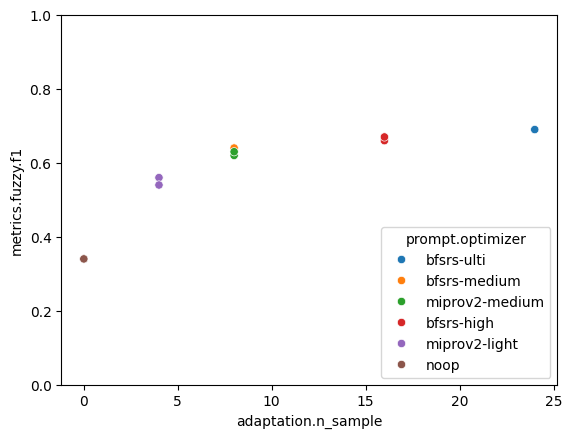

In [14]:
prompt_df = df[df["adaptation.method"] == "prompting"]
ax = sns.scatterplot(x="adaptation.n_sample", y="metrics.fuzzy.f1", data=prompt_df, hue="prompt.optimizer")
ax.set_ylim(0, 1)

(0.0, 1.0)

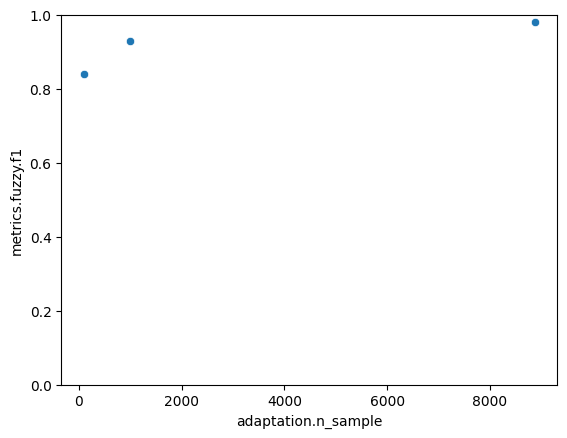

In [15]:
sft_df = df[df["adaptation.method"] == "sft"]
ax = sns.scatterplot(x="adaptation.n_sample", y="metrics.fuzzy.f1", data=sft_df)
ax.set_ylim(0, 1)